In [1]:

import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy as sp
from tsfresh.feature_extraction import feature_calculators
from scipy import signal
from scipy.signal import savgol_filter
from tqdm import tqdm_notebook as tqdm
#hay que escalar los valores de las features?
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
#Cross validation
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
#Product to test hyperparameters
import itertools

import os
print(os.listdir("./"))
from detect_peaks import detect_peaks
#150_000 is the number of the sample of each test, so is make up of appproximatly 36 steps of signals
seg_len = 150000
normalize_frec = 448800
min_threshold = 0.05  #to avoid the noisy segments of the signal


##Here hyperparemeters of the model
#Information of how many peaks, we need?
n_peaks = 3
#Augmention data, each segment delayed a n_factor part of 150000
n_factor = 3
#How much spliting on the segment data. 
n_spliting_seg = 50


['train.csv', 'First_attempt.ipynb', 'Untitled.ipynb', '.ipynb_checkpoints', 'sample_submission.csv', 'TestFeatures.ipynb', 'DataSplitingAndAnalysis.ipynb', 'detect_peaks.py', 'JoinAll.py', '__pycache__', 'test', 'detect_peaks_1.py', 'Analisis PSD.ipynb']


In [2]:
#In order to evalute the model
def evaluate(model, features, labels):
    predictions = model.predict(features)    
    mae = mean_absolute_error(labels, predictions)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    return predictions, mae


# This funtion calculate all features related with the PSD analisys. Just the 3 main maximun and the three respective 
#positions. Without sorting. Return a np.array of len(n_spliting_seg)*6. 
def features_psd(signal_seg):
    n_features_psd = n_peaks*2
    index_list = index_list_of_segment(n_spliting_seg)
    n_spliting_tot = len(index_list)
    features_PSD = np.zeros(n_features_psd*n_spliting_tot)
    count = 0
    for ini, fini in index_list:
        _frequencies, power_spectrum = get_segment_spectrum(signal_seg[ini:fini])
        #index_max = np.argmax(power_spectrum) 

        #print(feature_calculators.first_location_of_maximum(power_spectrum))
        #print('mean:', np.mean(power_spectrum))
        

        result = savgol_filter(power_spectrum, 5, 2)
        #taking the maximun indexes
        ind = detect_peaks(result,mpd=2, show=False)
        #Sorting the 3 higests values, index from min to max in the frequency feature
        index_sort = ind[np.argsort(result[ind])[-n_peaks:]]


        
        if max(result[index_sort]) >= min_threshold:
            frec_vect_norm = _frequencies[index_sort]/normalize_frec
            vec_result = result[index_sort]
            len_extra = n_peaks-len(frec_vect_norm) 
            if len_extra != 0:
                zero_aux = np.zeros(len_extra)
                frec_vect_norm = np.append(frec_vect_norm,zero_aux)
                vec_result = np.append(vec_result,zero_aux)
                
            features_PSD[count*n_features_psd:count*n_features_psd +n_peaks] = frec_vect_norm
            features_PSD[count*n_features_psd +n_peaks:count*n_features_psd +n_peaks*2] = vec_result
        count += 1
        
    return features_PSD

#This function return a list of index that takes account a delay(step_len) in the data, 
#len_total, is the data length, n_factor is inversly proportional to the step_len. IS given by how much we split the data.
def index_list_of_data_seg(len_total,n_factor = 3, seg_len = 150000):
    step_len = int(seg_len/n_factor)
    index_main = np.arange(0,len_total+1,step_len)
    index_list = []
    for i in np.arange(len(index_main)-n_factor):
        ini = index_main[i]
        fini = index_main[i+n_factor]
        index_list.append(np.array([ini,fini],dtype =int))        
    return index_list


#This function return a list of index that takes account the mixture of segments, holding the same len on each 'segment of segment'.
def index_list_of_segment(num_part,len_seg = 150000):
    #print('Computing list of array index (ini:fin), to spliting (on rigth way) the segment data')
    index_list = []
    len_part = int(len_seg/num_part)           #Length of partition
    idx_main = np.arange(0,len_seg+1,int(len_seg/num_part)) 
    for i in np.arange(len(idx_main)-1):
        ind_both = np.array( [idx_main[i],idx_main[i+1]],dtype='int')  
        index_list.append(ind_both)
        if i != len(idx_main)-2:
            ind_both = np.array( [idx_main[i+1]-int(len_part/2),idx_main[i+1]+int(len_part/2)],dtype='int')  
            index_list.append(ind_both)
    return index_list
#Definition of functions, to get the common features, and related to the spectrum shape.

sampling_frequency = 4e6

def get_spectrum(input_signal):
    """
    Get a pandas Series with the fourier power spectum for a given signal segment.
    """
    input_signal = np.asarray(input_signal.values, dtype='float64')
    
    # Remove the mean  
    input_signal -= input_signal.mean()  
    
    #Cleaning the signal noyse
    input_signal = savgol_filter(input_signal, 15, 2)
    
    
    # Estimate power spectral density using a periodogram.
    frequencies , power_spectrum = signal.periodogram(input_signal, sampling_frequency, scaling='spectrum')    
    
    # Run a running windows average of 10-points to smooth the signal.
    power_spectrum = pd.Series(power_spectrum, index=frequencies).rolling(window=10).mean()        
    
    return pd.Series(power_spectrum)

def get_segment_spectrum(segment_df):
    """
    Get the fourier power spectrum of a given segment.
    
    Returns the quake_time, frequencies, and power_spectrum
    """
    
    #quake_time =segment_df['time_to_failure'].values[-1]
    
    _power_spectrum = get_spectrum(segment_df['acoustic_data']).dropna() 
    
    # Keep only frequencies < 450khz (larger frequencies have a negligible contribution).
    _power_spectrum = _power_spectrum[_power_spectrum.index<450_000]
    
    # Keep one every 10 samples
    power_spectrum=_power_spectrum.values[::5]
    frequencies=_power_spectrum.index.values[::5]    
    
    return frequencies, power_spectrum

# A function to loop all the data extracting the nex index labels, the target array and the list of features.
##n_peaks
#Augmention data, each segment delayed a n_factor part of 150000
##n_factor
#How much spliting on the segment data. 
##n_spliting_seg

def extract_all_features(n_peaks = 3, n_factor = 3 ,n_spliting_seg = 50):
    #print(len(index_list_of_segment(50)))
    
    ##Some initializations:
    
    #Object to entry on file and extract data
    reader = pd.read_csv("./train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, iterator=True)
    #Total number of used data in every loop
    number_load_data = seg_len*500
    #Flag to finish the while in all the file
    flag_done_load = 1 
    #To recover the left data in each wise-loop
    data_left = pd.DataFrame({})
    #To count and it is usefull to generate the np array of new indexes. 
    total_num_segm_to_treat = 0
    #To stack the new indexes
    index_to_pd = 0
    #To save the target values
    target_values =  np.array([])
    #To list all the created features 
    features_list = []

    ##Loop over all the file.
    while flag_done_load:
        #Reading the file with number_load_data amount
        data = reader.get_chunk(number_load_data)
        #to check is not in the final loop
        len_total = len(data)
        print('It is taken a data of len: ',len_total)

        #assert(len(data) == number_load_data)
        #When reach the final loop:
        if len_total != number_load_data:
            print('Seems, the loading data, it is done.')
            flag_done_load = 0


        # after first cycle, we concatenate the left data in before loop-wise with the upload data from file
        data = pd.concat([data_left,data])
        len_total = len(data)
        #looking for index of cycles
        index_list_data = index_list_of_data_seg(len_total,n_factor)

        ini_back_up = 0
        for ini, fini in tqdm(index_list_data):   
        #for ini, fini in index_list_data:           
            total_num_segm_to_treat += 1
            index_to_pd = np.append(index_to_pd,total_num_segm_to_treat)
            signal_seg = data[:][ini:fini]
            target_values = np.append(target_values,signal_seg.time_to_failure.values[-1:], axis=0)
            features_list.append(features_psd(signal_seg))
            #target_values = signal_seg.time_to_failure.values[-1:]
            ini_back_up = ini

        step_len = int(seg_len/n_factor)
        data_left = data[:][ini_back_up+step_len:]
        print('Saving data left, at last loop-wise, data_left of len: ', len(data_left), 'from index', ini_back_up+step_len)


    print('Total number of segments:', total_num_segm_to_treat)
    return index_to_pd, target_values, features_list

def testing_randomForest(X, y, number_splits = 3):

    base_model = RandomForestRegressor(n_estimators = 100, n_jobs = 3, random_state = 11)


    kf = model_selection.KFold (n_splits = number_splits)
    kf.get_n_splits(y)
    _, ax = plt.subplots(nrows=number_splits, ncols=1, figsize=(24,4))
    index_fig = 0
    error_CV = 0
    for train_index , validation_index in kf.split(y):
        X_train , X_validation = X[ train_index ], X[ validation_index ]
        y_train , y_validation = y[ train_index ], y[ validation_index ]
        base_model.fit(X_train, y_train)
        prediction , mae = evaluate(base_model, X_validation, y_validation)
        error_CV += mae
        #ax[i].set_title('title of first')
        ax[index_fig].plot(y_validation) # plot for first subplot
        ax[index_fig].plot(prediction) # plot for first subplot
        index_fig += 1
    error_CV = error_CV/number_splits
    print('Mean error in cross validation with ', number_splits , ' is: ', error_CV)
    return error_CV


In [ ]:
#list_hyp = [[1,2,3], [3, 5, 10], [10, 50, 70]] one peak not change in n_spliting_seg
#list_hyp = [[2,3], [3, 5, 10], [10, 50]]
list_hyp = [[1], [20,50,100], [1]]


# Make a cartesian product to get all the combinations
product = [ele for ele in itertools.product(*list_hyp)]
#print("Test values for tau, mu and gamma:")
#print(product)
scores = []

for n_peaks_i, n_factor_i, n_spliting_seg_i in tqdm(product):
    print('Testing with ', n_peaks_i, ' peaks,',' with n_factor(1/step):  ', n_factor_i, ', and spliting the segment ',n_spliting_seg_i , 'times.' )
    print('And a number of PSD features: ', 2*n_peaks_i*len(index_list_of_segment(n_spliting_seg_i)), ' per segment.' )
    
    index_to_pd, target_values, features_list = extract_all_features(n_peaks = n_peaks_i, n_factor = n_factor_i ,n_spliting_seg = n_spliting_seg_i)
    y = target_values
    X = np.asarray(features_list)
    number_features = X.shape[1] 
    error_CV = testing_randomForest(X, y)
    score_values = [n_peaks_i, n_factor_i, n_spliting_seg_i, error_CV]
    scores.append(score_values)

print(scores)

Testing with  1  peaks,  with n_factor(1/step):   20 , and spliting the segment  1 times.
And a number of PSD features:  2  per segment.
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 74857500
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  142500 from index 75000000
It is taken a data of len:  29145480
Seems, the loading data, it is done.


Saving data left, at last loop-wise, data_left of len:  142980 from index 29145000
Total number of segments: 83867
Model Performance
Mean Absolute Error: 2.1103.
Model Performance
Mean Absolute Error: 2.4271.
Model Performance
Mean Absolute Error: 2.0520.
Mean error in cross validation with  3  is:  2.196477007701971
Testing with  1  peaks,  with n_factor(1/step):   50 , and spliting the segment  1 times.
And a number of PSD features:  2  per segment.
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  147000 from index 74853000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  147000 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  147000 from index 75000000
It is taken a data of len:  75000000


Saving data left, at last loop-wise, data_left of len:  147000 from index 75000000
It is taken a data of len:  75000000


Results:
Testing with  1  peaks,  with n_factor(1/step):   3 
and we have the same results for spliting the segment 1,2, 10 times, 50 and 70 times.
(10 times) And a number of PSD features:  38  per segment.
(50)And a number of PSD features:  198  per segment.
(70) And a number of PSD features:  278  per segment.

Mean Absolute Error: 2.1467.
Mean Absolute Error: 2.4459.
Mean Absolute Error: 2.0839.
Mean error in cross validation with  3  is:  2.2254824865483323

Testing with  1  peaks,  with n_factor(1/step):   5 
and we have the same results for spliting the segment  10 times, 50 and 70 times.
And a number of PSD features:  38  per segment.
And a number of PSD features:  198  per segment.
And a number of PSD features:  278  per segment.

Mean Absolute Error: 2.1198.
Mean Absolute Error: 2.4413.
Mean Absolute Error: 2.0583.
Mean error in cross validation with  3  is:  2.2064410700871124

Testing with  2  peaks,  with n_factor(1/step):   3 
and we have the same results for spliting the segment  10 times, 50 times.  
And a number of PSD features:  76  per segment.
And a number of PSD features:  396  per segment.

Mean Absolute Error: 2.1467.
Mean Absolute Error: 2.4459.
Mean Absolute Error: 2.0839.
Mean error in cross validation with  3  is:  2.2254824865483323

Testing with  2  peaks,  with n_factor(1/step):   5 
and spliting the segment  10 times.
And a number of PSD features:  76  per segment.

Mean Absolute Error: 2.1184.
Mean Absolute Error: 2.4267.
Mean Absolute Error: 2.0494.
Mean error in cross validation with  3  is:  2.1981884738134334

Testing with  3  peaks,  with n_factor(1/step):   3 , and spliting the segment  10 times.
And a number of PSD features:  114  per segment.

Mean Absolute Error: 2.1467.
Mean Absolute Error: 2.4459.
Mean Absolute Error: 2.0839.
Mean error in cross validation with  3  is:  2.2254824865483323



In [ ]:
#Other possible features:
#Limit the range.
output["new_std"]=data[np.logical_and(0<=data,data<=10)].std()
   
tc = ["q05_roll_std_100", "q99_roll_mean_1000",  "q05_roll_mean_100", "q05_roll_std_1000", "max_roll_mean_1000", "iqr", "q95"]
windows 100 y 1000
x_roll_std = x.rolling(windows).std().dropna().values
X_tr['q05_roll_std_'  + str(windows)] = np.quantile(x_roll_std, 0.05)
x_roll_mean = x.rolling(windows).mean().dropna().values
X_tr[ 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)

windows 1000
X_tr[ 'max_roll_mean_' + str(windows)] = x_roll_mean.max()

X_tr['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
X_tr['q95'] = np.quantile(x, 0.95)

In [23]:
def make_prediction(features, column_name="prediction"):
    """ custom prediction function that returns a dataframe in stead of a numpy array"""
    prediction = pd.DataFrame(
        index=features.index, data=model.predict(features.values), columns=[column_name]
    )
    return prediction

#It returns the features for all the test, in 'pd' format 
def load_test_features():
    """ load raw test data and transform to a feature dataframe """
    print("loading train segment ids...")
    seg_ids = pd.read_csv("./sample_submission.csv", index_col="seg_id").index
    feature_values = np.zeros((seg_ids.shape[0], number_features))
    print("converting test segments into feature dataframes. ")
    for i, seg_id in enumerate(tqdm(seg_ids)):
        segment = pd.read_csv(
            filepath_or_buffer=f"./test/{seg_id}.csv",
            dtype={"acoustic_data": np.int16, "time_to_failure": np.float32},
        )
        
        feature_row = features_psd(segment)
        feature_values[i, :] = feature_row
    features = pd.DataFrame(index=seg_ids, data=feature_values, columns=feature_row.columns)
    print("test feature dataframe created")
    return features

In [24]:
test_features = load_test_features()
#No recuerdo si es nescesario transformar los parametros para la random forest ya implemetada
#feature_scaler.transform(test_features)
prediction = make_prediction(test_features, column_name="time_to_failure")
prediction.time_to_failure[prediction.time_to_failure < 0] = 0
prediction.index.name = "seg_id"
prediction.to_csv("submission.csv")
prediction.head()

loading train segment ids...
converting test segments into feature dataframes. 


KeyboardInterrupt: 

Acá miramos del último segmento como se comporta el PSD


Computing list of array index (ini:fin), to spliting (on rigth way) the segment data
0.5454545454545454
mean: 0.042070164191524026
Maximun:  0.1740654013546003


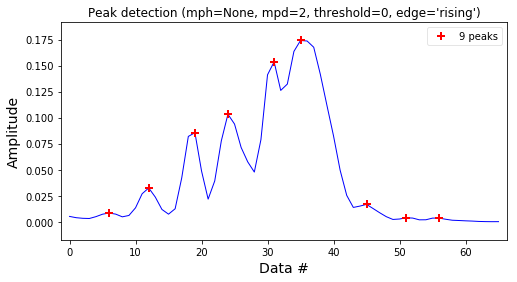

[0.38324421 0.48722519 0.5466429 ]
[0.10323921 0.15358613 0.1740654 ]
[0.38324421 0.48722519 0.5466429 ]
[0.10323921 0.15358613 0.1740654 ]
0.5151515151515151
mean: 0.020694903115058543
Maximun:  0.09267626937029708


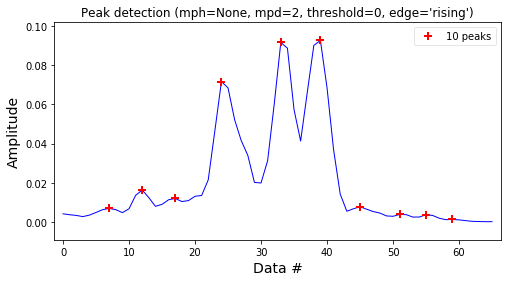

[0.38324421 0.51693405 0.60606061]
[0.07169738 0.09172274 0.09267627]
[0.38324421 0.51693405 0.60606061]
[0.07169738 0.09172274 0.09267627]
0.5757575757575758
mean: 0.005801925479574562
Maximun:  0.013731158856145606


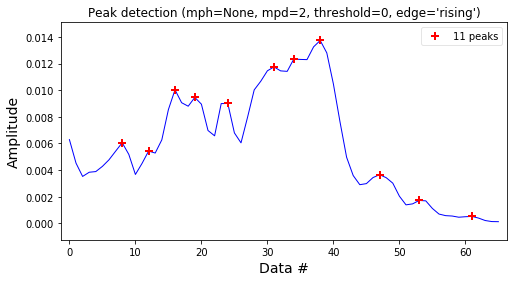

[0.48722519 0.53178847 0.59120618]
[0.01174691 0.01233795 0.01373116]
[0.48722519 0.53178847 0.59120618]
[0.01174691 0.01233795 0.01373116]
0.3484848484848485
mean: 0.004603256468649383
Maximun:  0.012357823093225362


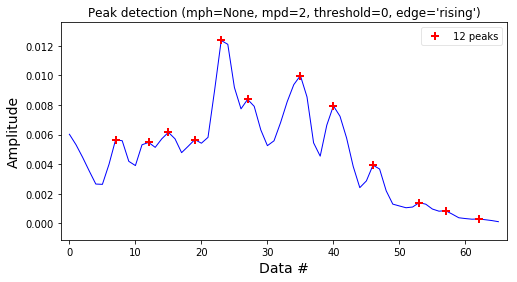

[0.36838978 0.42780749 0.5466429 ]
[0.01235782 0.00837813 0.00998312]
[0.42780749 0.5466429  0.36838978]
[0.00837813 0.00998312 0.01235782]
0.2878787878787879
mean: 0.004596193772710249
Maximun:  0.013341162229030024


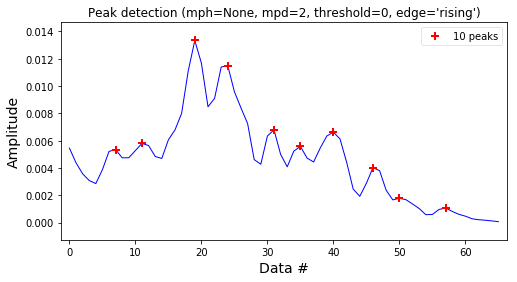

[0.30897207 0.38324421 0.48722519]
[0.01334116 0.0114822  0.00679742]
[0.48722519 0.38324421 0.30897207]
[0.00679742 0.0114822  0.01334116]
0.2878787878787879
mean: 0.005460725275542191
Maximun:  0.013208829336061155


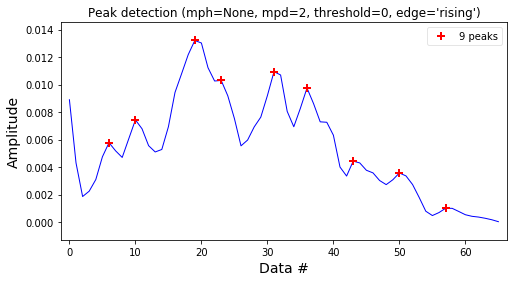

[0.30897207 0.36838978 0.48722519]
[0.01320883 0.01030271 0.01094128]
[0.36838978 0.48722519 0.30897207]
[0.01030271 0.01094128 0.01320883]
0.4393939393939394
mean: 0.005208148077556181
Maximun:  0.012884223349762101


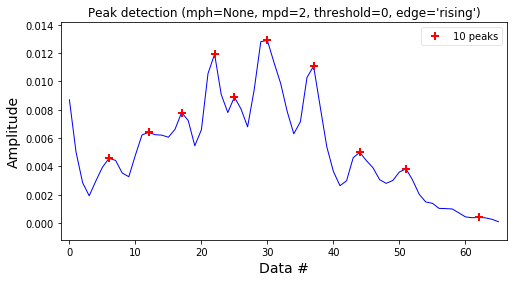

[0.35353535 0.47237077 0.57635175]
[0.01191772 0.01288422 0.01107379]
[0.57635175 0.35353535 0.47237077]
[0.01107379 0.01191772 0.01288422]
0.4393939393939394
mean: 0.004800316763742147
Maximun:  0.012462049464493093


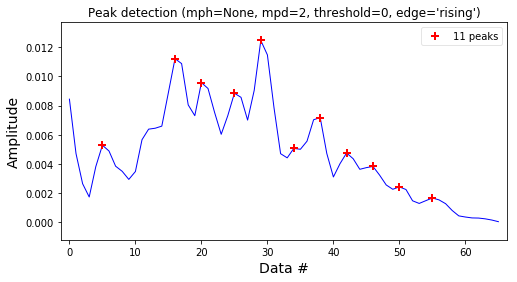

[0.26440879 0.3238265  0.45751634]
[0.01121477 0.00957128 0.01246205]
[0.3238265  0.26440879 0.45751634]
[0.00957128 0.01121477 0.01246205]
0.25757575757575757
mean: 0.0048033382592870015
Maximun:  0.01324485995034511


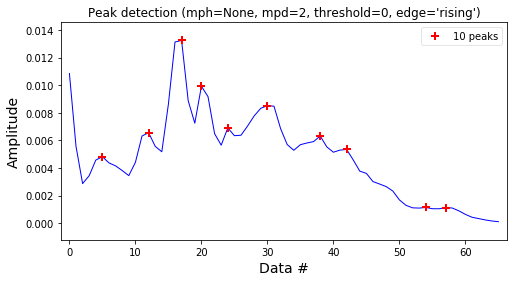

[0.27926322 0.3238265  0.47237077]
[0.01324486 0.00992759 0.00851933]
[0.47237077 0.3238265  0.27926322]
[0.00851933 0.00992759 0.01324486]
0.2727272727272727
mean: 0.005797158437022299
Maximun:  0.015276924973281238


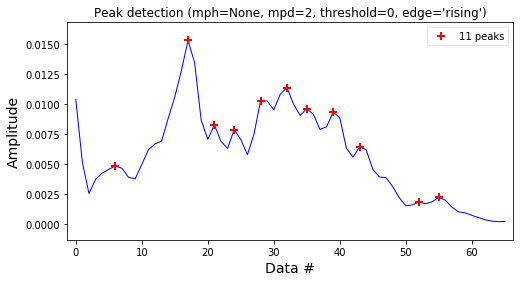

[0.27926322 0.44266191 0.50207962]
[0.01527692 0.0102529  0.01135478]
[0.44266191 0.50207962 0.27926322]
[0.0102529  0.01135478 0.01527692]
0.22727272727272727
mean: 0.006100561052756367
Maximun:  0.012732525295411102


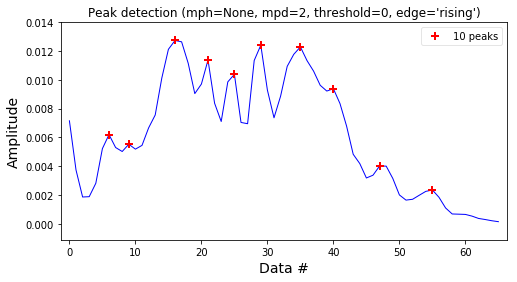

[0.26440879 0.45751634 0.5466429 ]
[0.01273253 0.01240704 0.01228458]
[0.5466429  0.45751634 0.26440879]
[0.01228458 0.01240704 0.01273253]
0.5606060606060606
mean: 0.006003133280379601
Maximun:  0.01549456865478891


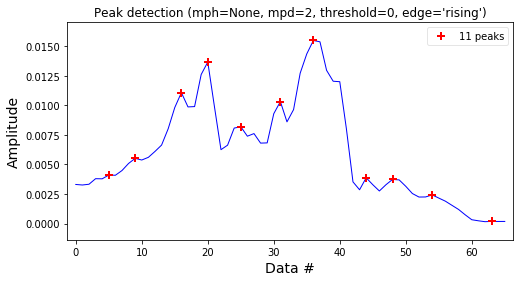

[0.26440879 0.3238265  0.56149733]
[0.0110794  0.01366963 0.01549457]
[0.26440879 0.3238265  0.56149733]
[0.0110794  0.01366963 0.01549457]
0.45454545454545453
mean: 0.006701853616839182
Maximun:  0.016788483850737924


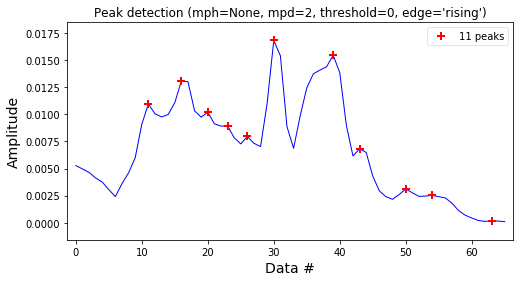

[0.26440879 0.47237077 0.60606061]
[0.01305876 0.01678848 0.01543357]
[0.26440879 0.60606061 0.47237077]
[0.01305876 0.01543357 0.01678848]
0.45454545454545453
mean: 0.0055202217196461826
Maximun:  0.01232407839021103


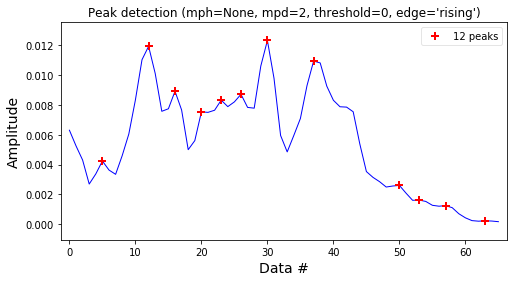

[0.20499109 0.47237077 0.57635175]
[0.01193283 0.01232408 0.01094291]
[0.57635175 0.20499109 0.47237077]
[0.01094291 0.01193283 0.01232408]
0.45454545454545453
mean: 0.00444930116947957
Maximun:  0.01150405310024884


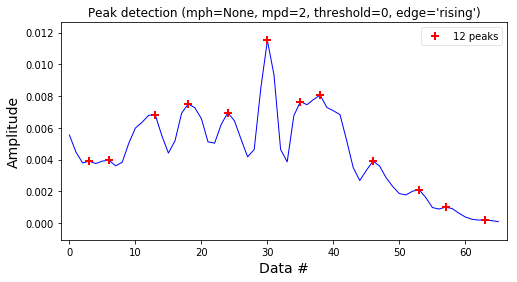

[0.47237077 0.5466429  0.59120618]
[0.01150405 0.00765376 0.00806599]
[0.5466429  0.59120618 0.47237077]
[0.00765376 0.00806599 0.01150405]
0.3333333333333333
mean: 0.005412103115706867
Maximun:  0.014675781204979402


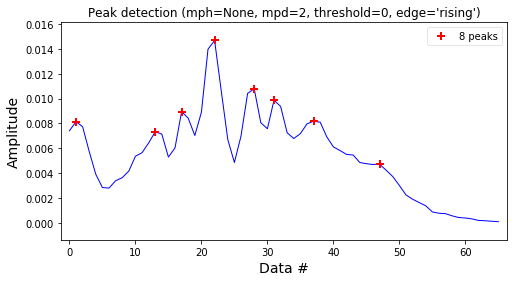

[0.35353535 0.44266191 0.48722519]
[0.01467578 0.01079365 0.00986916]
[0.48722519 0.44266191 0.35353535]
[0.00986916 0.01079365 0.01467578]
0.3181818181818182
mean: 0.005691331589592736
Maximun:  0.013589752162271365


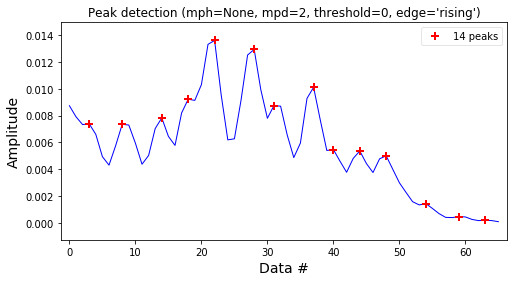

[0.35353535 0.44266191 0.57635175]
[0.01358975 0.01292201 0.01010549]
[0.57635175 0.44266191 0.35353535]
[0.01010549 0.01292201 0.01358975]
0.4696969696969697
mean: 0.004594562893735846
Maximun:  0.009646683781655705


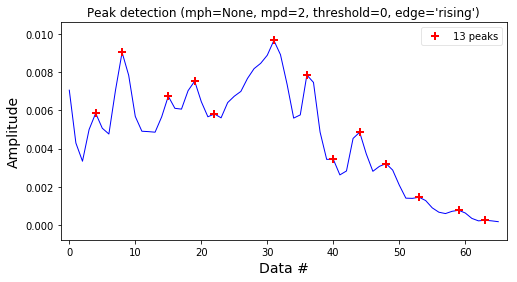

[0.14557338 0.48722519 0.56149733]
[0.0090243  0.00964668 0.00784024]
[0.56149733 0.14557338 0.48722519]
[0.00784024 0.0090243  0.00964668]
0.18181818181818182
mean: 0.004896236900696642
Maximun:  0.01191734494648636


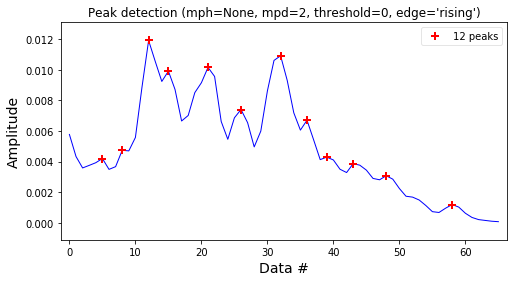

[0.20499109 0.33868093 0.50207962]
[0.01191734 0.01015784 0.01091841]
[0.33868093 0.50207962 0.20499109]
[0.01015784 0.01091841 0.01191734]
0.5606060606060606
mean: 0.00811081259242257
Maximun:  0.040574532075041414


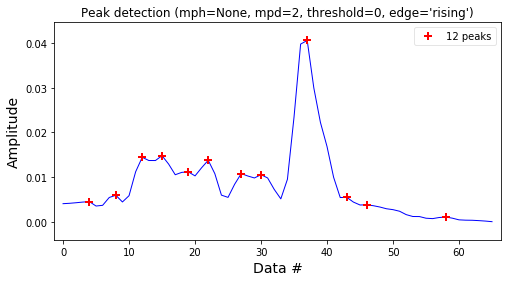

[0.20499109 0.24955437 0.57635175]
[0.01445265 0.01480546 0.04057453]
[0.20499109 0.24955437 0.57635175]
[0.01445265 0.01480546 0.04057453]
0.5606060606060606
mean: 0.00815253201401725
Maximun:  0.04191394754694665


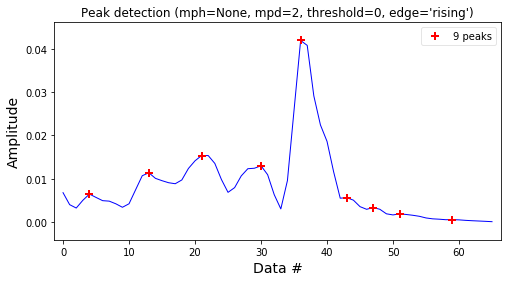

[0.33868093 0.47237077 0.56149733]
[0.0153658  0.01299618 0.04191395]
[0.47237077 0.33868093 0.56149733]
[0.01299618 0.0153658  0.04191395]
0.3484848484848485
mean: 0.005440788392918331
Maximun:  0.014371007266290762


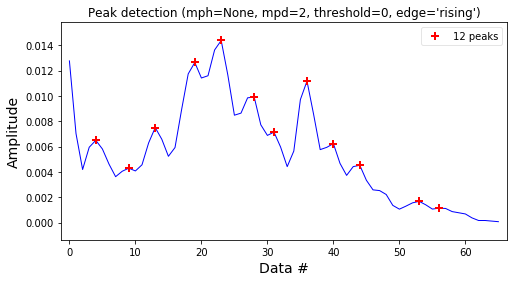

[0.30897207 0.36838978 0.56149733]
[0.01263684 0.01437101 0.0111665 ]
[0.56149733 0.30897207 0.36838978]
[0.0111665  0.01263684 0.01437101]
0.5606060606060606
mean: 0.005095886266410992
Maximun:  0.012136849085943292


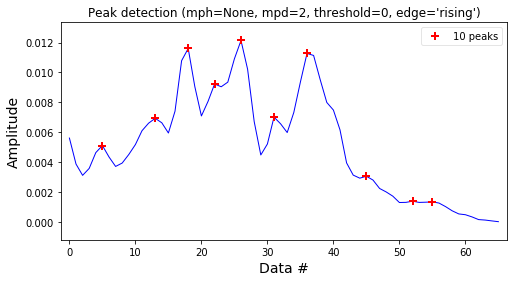

[0.29411765 0.41295306 0.56149733]
[0.01160254 0.01213685 0.01127319]
[0.56149733 0.29411765 0.41295306]
[0.01127319 0.01160254 0.01213685]
0.3787878787878788
mean: 0.0052071597265761285
Maximun:  0.011206980501972774


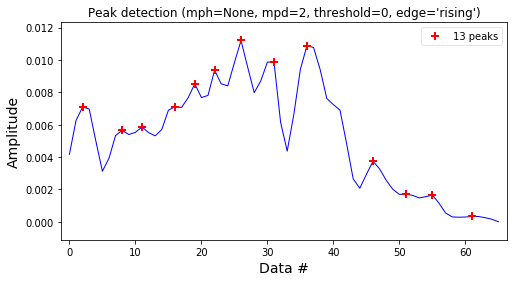

[0.41295306 0.48722519 0.56149733]
[0.01120698 0.00987333 0.01089648]
[0.48722519 0.56149733 0.41295306]
[0.00987333 0.01089648 0.01120698]
0.42424242424242425
mean: 0.004808325970133945
Maximun:  0.010716409072123699


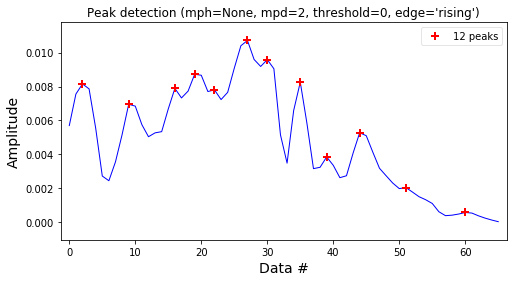

[0.30897207 0.42780749 0.47237077]
[0.00872635 0.01071641 0.00958628]
[0.30897207 0.47237077 0.42780749]
[0.00872635 0.00958628 0.01071641]
0.2878787878787879
mean: 0.004281894572904838
Maximun:  0.009193741776205692


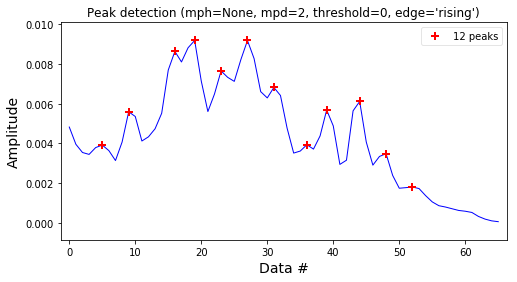

[0.26440879 0.30897207 0.42780749]
[0.00864379 0.00919374 0.00919302]
[0.26440879 0.42780749 0.30897207]
[0.00864379 0.00919302 0.00919374]
0.25757575757575757
mean: 0.004539127673340925
Maximun:  0.011617421366929555


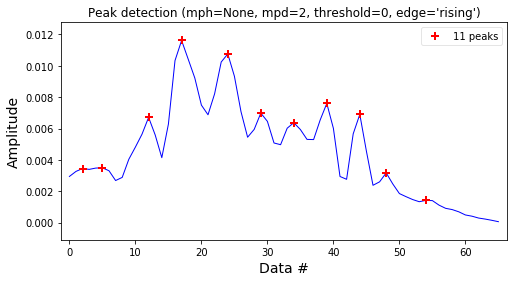

[0.27926322 0.38324421 0.60606061]
[0.01161742 0.01075836 0.00760359]
[0.60606061 0.38324421 0.27926322]
[0.00760359 0.01075836 0.01161742]
0.2727272727272727
mean: 0.005934721531939066
Maximun:  0.015815548985888224


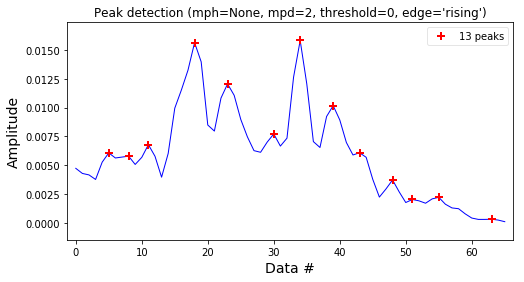

[0.29411765 0.36838978 0.53178847]
[0.01562989 0.01204844 0.01581555]
[0.36838978 0.29411765 0.53178847]
[0.01204844 0.01562989 0.01581555]
0.3333333333333333
mean: 0.006202165559505437
Maximun:  0.0148966854753174


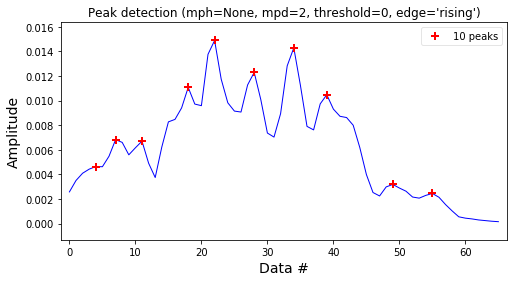

[0.35353535 0.44266191 0.53178847]
[0.01489669 0.01230126 0.01429869]
[0.44266191 0.53178847 0.35353535]
[0.01230126 0.01429869 0.01489669]
0.45454545454545453
mean: 0.005749004550971046
Maximun:  0.017372547592206286


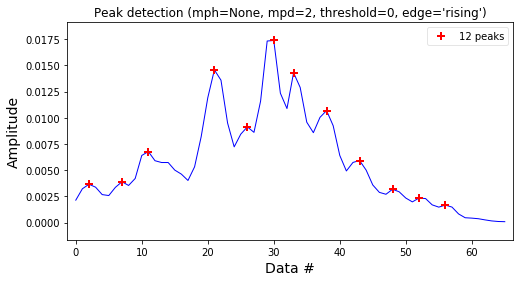

[0.33868093 0.47237077 0.51693405]
[0.01456794 0.01737255 0.01429807]
[0.51693405 0.33868093 0.47237077]
[0.01429807 0.01456794 0.01737255]
0.45454545454545453
mean: 0.005600382203405145
Maximun:  0.014810701871201707


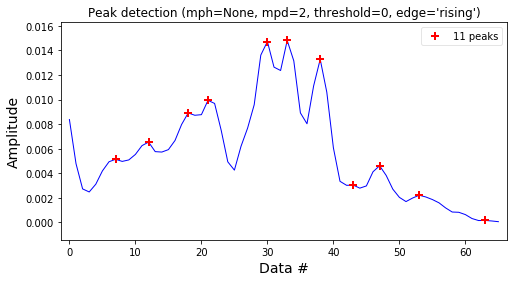

[0.47237077 0.51693405 0.59120618]
[0.01472571 0.0148107  0.01327881]
[0.59120618 0.47237077 0.51693405]
[0.01327881 0.01472571 0.0148107 ]
0.4090909090909091
mean: 0.0057181175453146675
Maximun:  0.011906585293591553


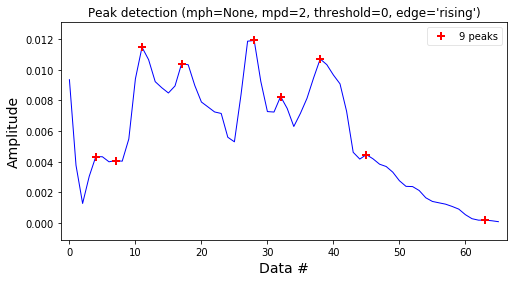

[0.19013666 0.44266191 0.59120618]
[0.01146775 0.01190659 0.01069895]
[0.59120618 0.19013666 0.44266191]
[0.01069895 0.01146775 0.01190659]
0.4090909090909091
mean: 0.005518898884176693
Maximun:  0.012107752603778672


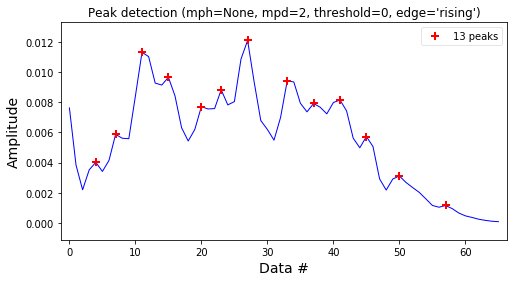

[0.19013666 0.24955437 0.42780749]
[0.01132425 0.00966637 0.01210775]
[0.24955437 0.19013666 0.42780749]
[0.00966637 0.01132425 0.01210775]
0.5151515151515151
mean: 0.004555020819001299
Maximun:  0.009521432785594515


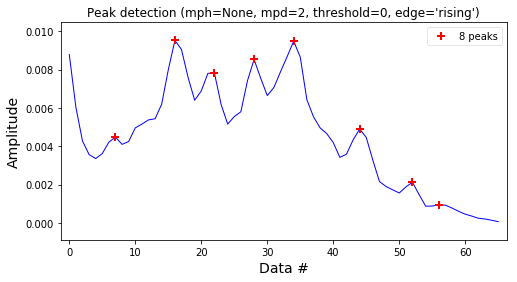

[0.26440879 0.44266191 0.53178847]
[0.00952143 0.00852979 0.00948483]
[0.44266191 0.53178847 0.26440879]
[0.00852979 0.00948483 0.00952143]
0.5909090909090909
mean: 0.051600367361065394
Maximun:  0.5067881101869809


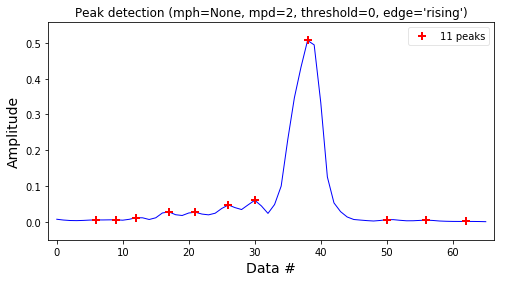

[0.41295306 0.47237077 0.59120618]
[0.04696176 0.05998004 0.50678811]
[0.41295306 0.47237077 0.59120618]
[0.04696176 0.05998004 0.50678811]
0.5909090909090909
mean: 0.05637778143381899
Maximun:  0.4971949294716127


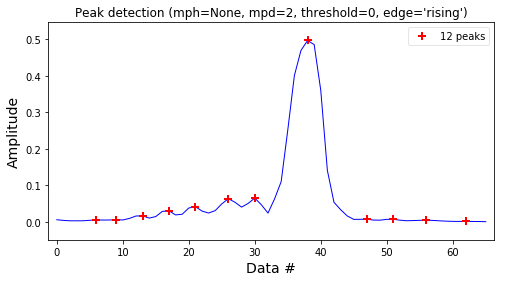

[0.41295306 0.47237077 0.59120618]
[0.06325177 0.06496278 0.49719493]
[0.41295306 0.47237077 0.59120618]
[0.06325177 0.06496278 0.49719493]
0.5454545454545454
mean: 0.011156342257217464
Maximun:  0.06387237002814154


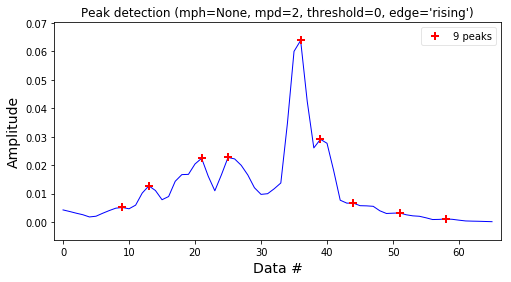

[0.39809863 0.56149733 0.60606061]
[0.02272697 0.06387237 0.02910167]
[0.39809863 0.60606061 0.56149733]
[0.02272697 0.02910167 0.06387237]
0.5606060606060606
mean: 0.013702184986479488
Maximun:  0.09272208781919344


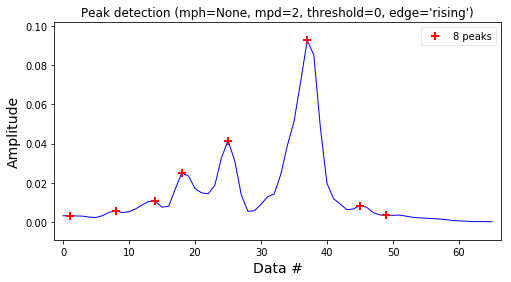

[0.29411765 0.39809863 0.57635175]
[0.02494884 0.04157204 0.09272209]
[0.29411765 0.39809863 0.57635175]
[0.02494884 0.04157204 0.09272209]
0.5606060606060606
mean: 0.012643216542654162
Maximun:  0.07708275252710745


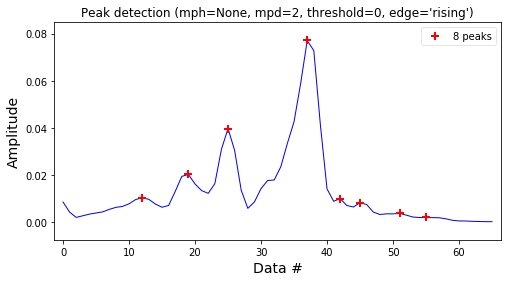

[0.30897207 0.39809863 0.57635175]
[0.02013012 0.03965024 0.07708275]
[0.30897207 0.39809863 0.57635175]
[0.02013012 0.03965024 0.07708275]
0.3787878787878788
mean: 0.008910157880427068
Maximun:  0.040571509333414774


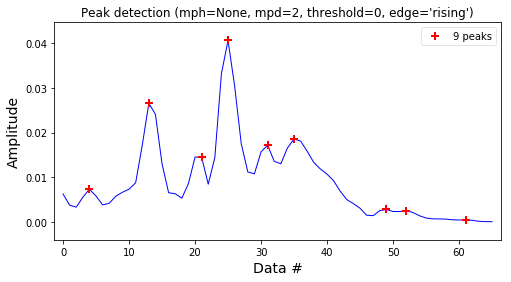

[0.21984551 0.39809863 0.5466429 ]
[0.02653351 0.04057151 0.0185593 ]
[0.5466429  0.21984551 0.39809863]
[0.0185593  0.02653351 0.04057151]
0.3787878787878788
mean: 0.01001495238054019
Maximun:  0.044337509446650325


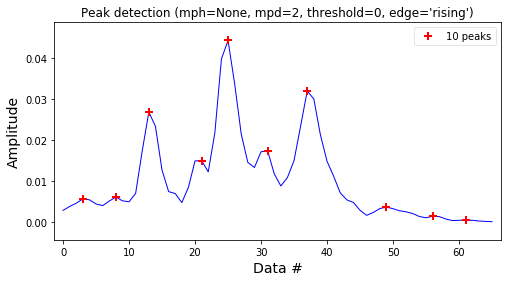

[0.21984551 0.39809863 0.57635175]
[0.02686261 0.04433751 0.03199435]
[0.21984551 0.57635175 0.39809863]
[0.02686261 0.03199435 0.04433751]
0.5151515151515151
mean: 0.009804307033196137
Maximun:  0.03511853644158031


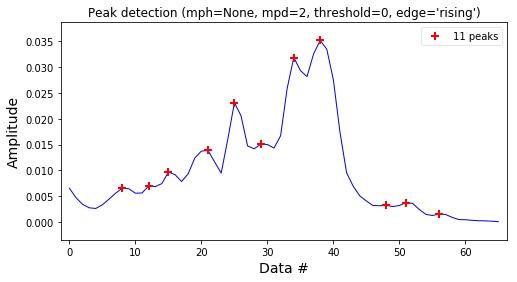

[0.39809863 0.53178847 0.59120618]
[0.02309222 0.03182166 0.03511854]
[0.39809863 0.53178847 0.59120618]
[0.02309222 0.03182166 0.03511854]
0.5151515151515151
mean: 0.02242119421369992
Maximun:  0.09047590841560202


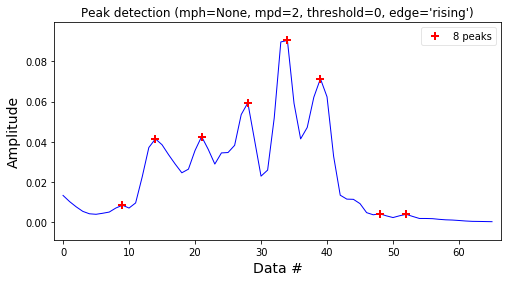

[0.44266191 0.53178847 0.60606061]
[0.05936599 0.09047591 0.07139899]
[0.44266191 0.60606061 0.53178847]
[0.05936599 0.07139899 0.09047591]
0.5151515151515151
mean: 0.023824729064130683
Maximun:  0.09260454647810076


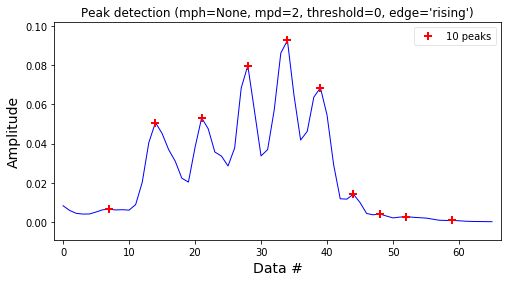

[0.44266191 0.53178847 0.60606061]
[0.07973562 0.09260455 0.06846583]
[0.60606061 0.44266191 0.53178847]
[0.06846583 0.07973562 0.09260455]
0.5303030303030303
mean: 0.013083513284565742
Maximun:  0.07599339603992528


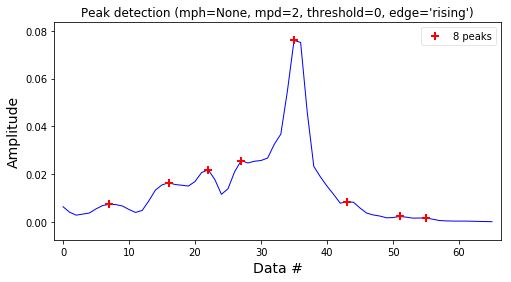

[0.35353535 0.42780749 0.5466429 ]
[0.02178038 0.02568469 0.0759934 ]
[0.35353535 0.42780749 0.5466429 ]
[0.02178038 0.02568469 0.0759934 ]
0.5454545454545454
mean: 0.008557291801468319
Maximun:  0.05210709244272932


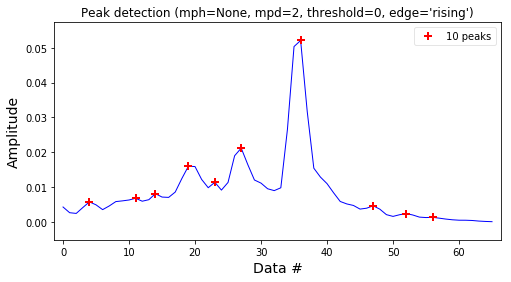

[0.30897207 0.42780749 0.56149733]
[0.01600064 0.02118243 0.05210709]
[0.30897207 0.42780749 0.56149733]
[0.01600064 0.02118243 0.05210709]
0.5454545454545454
mean: 0.005947254790781617
Maximun:  0.016115619751802666


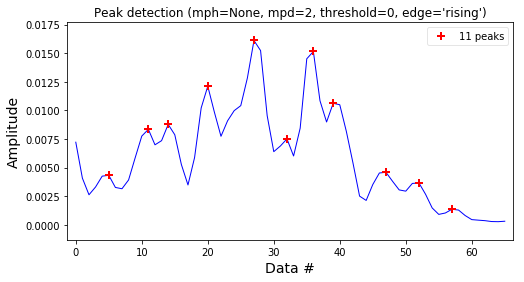

[0.3238265  0.42780749 0.56149733]
[0.01211917 0.01611562 0.01515432]
[0.3238265  0.56149733 0.42780749]
[0.01211917 0.01515432 0.01611562]
0.5454545454545454
mean: 0.005620797581237152
Maximun:  0.017273358482726788


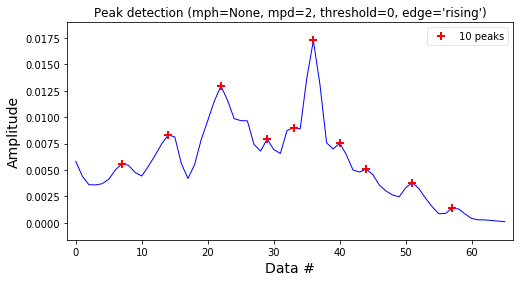

[0.35353535 0.51693405 0.56149733]
[0.01295586 0.00902022 0.01727336]
[0.51693405 0.35353535 0.56149733]
[0.00902022 0.01295586 0.01727336]
0.5454545454545454
mean: 0.022228858698768915
Maximun:  0.2235032027830869


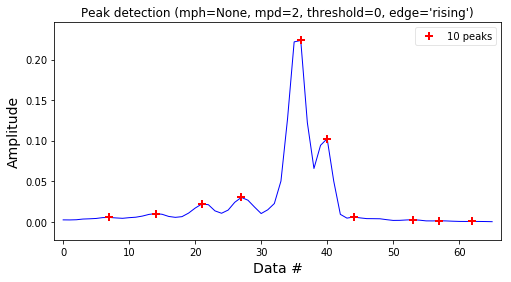

[0.42780749 0.56149733 0.62091503]
[0.03001136 0.2235032  0.10241342]
[0.42780749 0.62091503 0.56149733]
[0.03001136 0.10241342 0.2235032 ]
0.5454545454545454
mean: 0.022712713052061663
Maximun:  0.22737816332118793


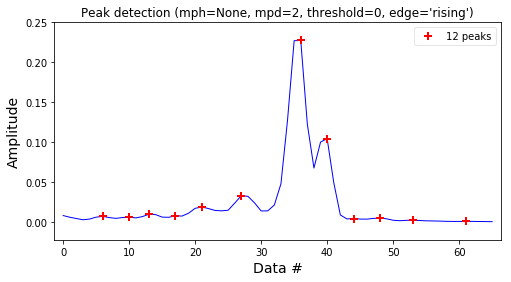

[0.42780749 0.56149733 0.62091503]
[0.03267183 0.22737816 0.10424393]
[0.42780749 0.62091503 0.56149733]
[0.03267183 0.10424393 0.22737816]
0.4393939393939394
mean: 0.005492437234290032
Maximun:  0.013118990003270478


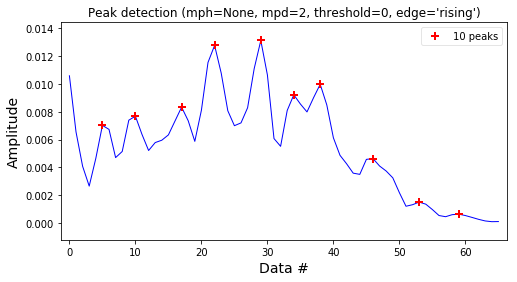

[0.35353535 0.45751634 0.59120618]
[0.01276503 0.01311899 0.00997164]
[0.59120618 0.35353535 0.45751634]
[0.00997164 0.01276503 0.01311899]
0.45454545454545453
mean: 0.005324545919525443
Maximun:  0.012854151224402829


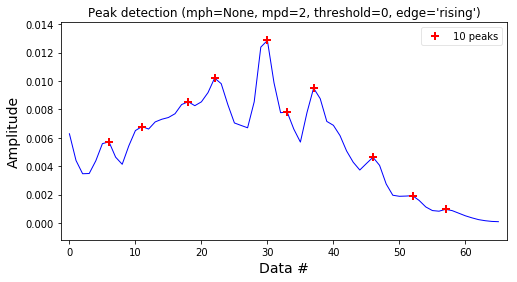

[0.35353535 0.47237077 0.57635175]
[0.01020293 0.01285415 0.00949913]
[0.57635175 0.35353535 0.47237077]
[0.00949913 0.01020293 0.01285415]
0.3484848484848485
mean: 0.005224429112916861
Maximun:  0.012661571124949818


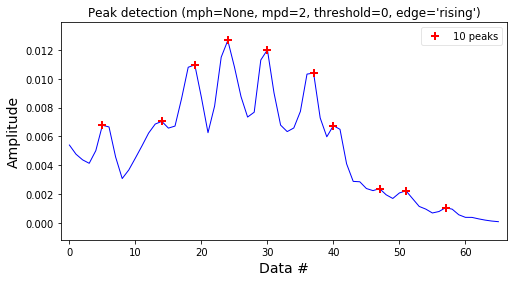

[0.30897207 0.38324421 0.47237077]
[0.01096802 0.01266157 0.01201395]
[0.30897207 0.47237077 0.38324421]
[0.01096802 0.01201395 0.01266157]
0.3484848484848485
mean: 0.005072208116585958
Maximun:  0.012773596540752026


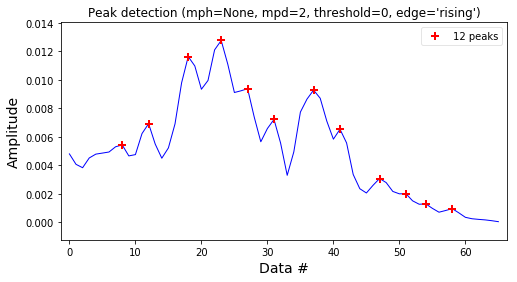

[0.29411765 0.36838978 0.42780749]
[0.01164218 0.0127736  0.00938701]
[0.42780749 0.29411765 0.36838978]
[0.00938701 0.01164218 0.0127736 ]
0.5757575757575758
mean: 0.014752032685939446
Maximun:  0.08607079303141629


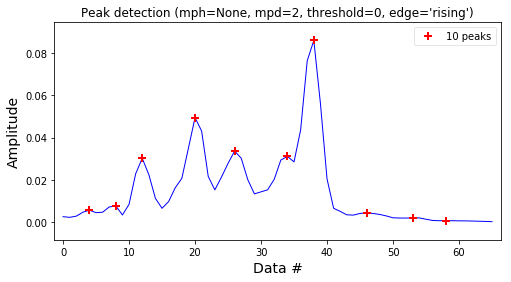

[0.3238265  0.41295306 0.59120618]
[0.04943546 0.03359765 0.08607079]
[0.41295306 0.3238265  0.59120618]
[0.03359765 0.04943546 0.08607079]
0.5757575757575758
mean: 0.015205603474370779
Maximun:  0.08229160212894109


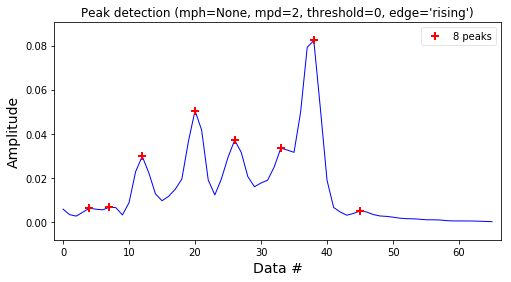

[0.3238265  0.41295306 0.59120618]
[0.05044556 0.03705424 0.0822916 ]
[0.41295306 0.3238265  0.59120618]
[0.03705424 0.05044556 0.0822916 ]
0.30303030303030304
mean: 0.0053210858730732445
Maximun:  0.01643941520167728


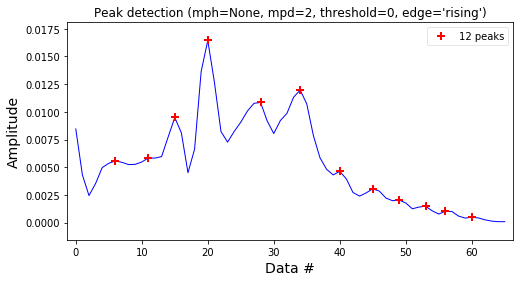

[0.3238265  0.44266191 0.53178847]
[0.01643942 0.01084652 0.0119682 ]
[0.44266191 0.53178847 0.3238265 ]
[0.01084652 0.0119682  0.01643942]
0.30303030303030304
mean: 0.005521573891705763
Maximun:  0.01353192458660867


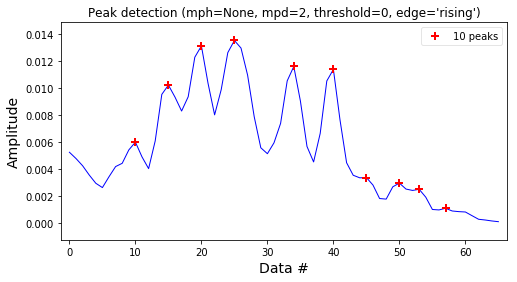

[0.3238265  0.39809863 0.53178847]
[0.01312774 0.01353192 0.01160295]
[0.53178847 0.3238265  0.39809863]
[0.01160295 0.01312774 0.01353192]
0.3939393939393939
mean: 0.005433935686481281
Maximun:  0.013854086631350671


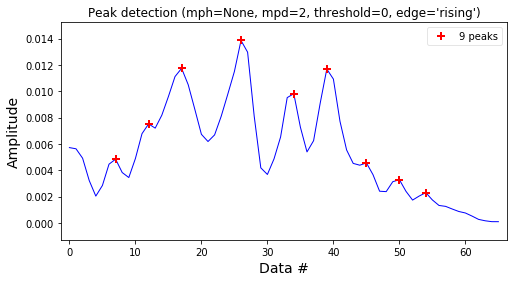

[0.27926322 0.41295306 0.60606061]
[0.01174024 0.01385409 0.01168428]
[0.60606061 0.27926322 0.41295306]
[0.01168428 0.01174024 0.01385409]
0.25757575757575757
mean: 0.0049813501492474155
Maximun:  0.011518863400933315


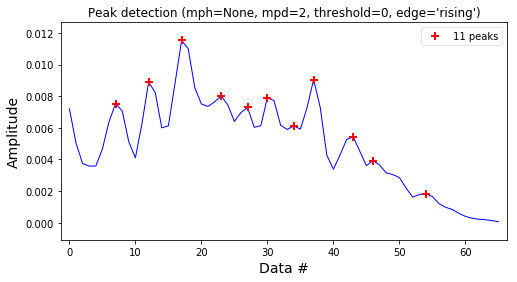

[0.20499109 0.27926322 0.57635175]
[0.0088827  0.01151886 0.00904865]
[0.20499109 0.57635175 0.27926322]
[0.0088827  0.00904865 0.01151886]
0.3333333333333333
mean: 0.005307748555294507
Maximun:  0.01371231048885671


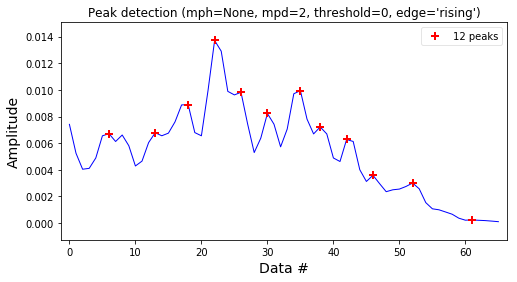

[0.35353535 0.41295306 0.5466429 ]
[0.01371231 0.00981985 0.00994517]
[0.41295306 0.5466429  0.35353535]
[0.00981985 0.00994517 0.01371231]
0.3333333333333333
mean: 0.005761805492364977
Maximun:  0.012324758487502242


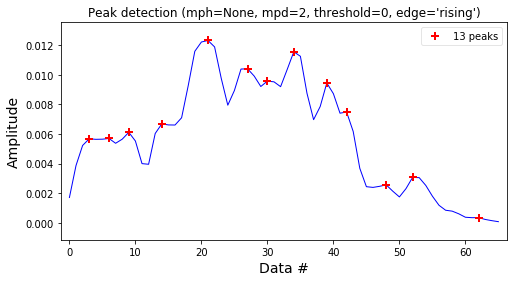

[0.33868093 0.42780749 0.53178847]
[0.01232476 0.01040848 0.0115613 ]
[0.42780749 0.53178847 0.33868093]
[0.01040848 0.0115613  0.01232476]
0.5757575757575758
mean: 0.017070431148446658
Maximun:  0.14532368599959694


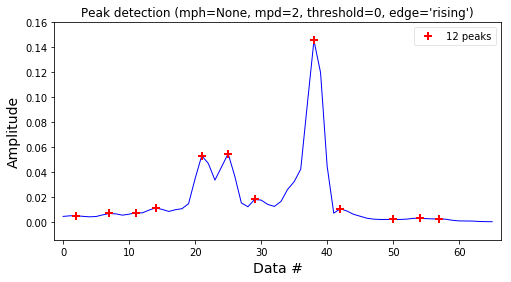

[0.33868093 0.39809863 0.59120618]
[0.05299106 0.05459215 0.14532369]
[0.33868093 0.39809863 0.59120618]
[0.05299106 0.05459215 0.14532369]
0.5757575757575758
mean: 0.016884509443774173
Maximun:  0.14873035215165553


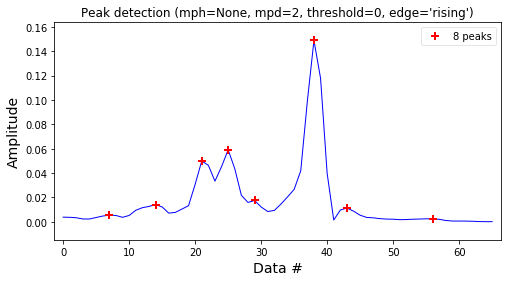

[0.33868093 0.39809863 0.59120618]
[0.04993185 0.05904632 0.14873035]
[0.33868093 0.39809863 0.59120618]
[0.04993185 0.05904632 0.14873035]
0.3939393939393939
mean: 0.0063687926744447855
Maximun:  0.01921924637932154


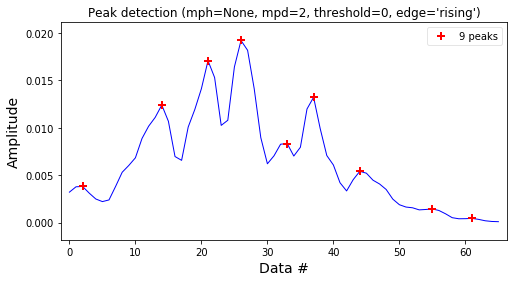

[0.33868093 0.41295306 0.57635175]
[0.01708455 0.01921925 0.01322163]
[0.57635175 0.33868093 0.41295306]
[0.01322163 0.01708455 0.01921925]
0.4090909090909091
mean: 0.005724078316662882
Maximun:  0.015748036061941986


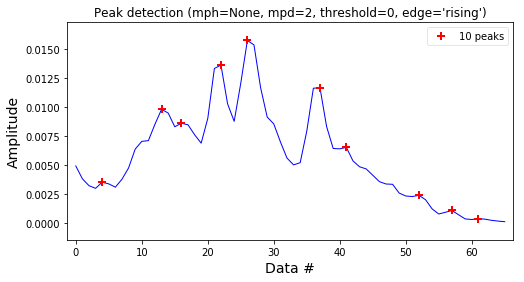

[0.35353535 0.41295306 0.57635175]
[0.0136199  0.01574804 0.01167097]
[0.57635175 0.35353535 0.41295306]
[0.01167097 0.0136199  0.01574804]
0.19696969696969696
mean: 0.00925431318102124
Maximun:  0.07054973406494378


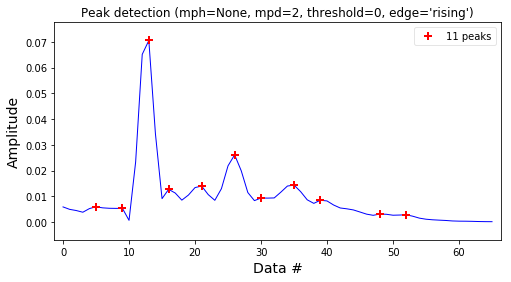

[0.21984551 0.41295306 0.5466429 ]
[0.07054973 0.02608407 0.01433255]
[0.5466429  0.41295306 0.21984551]
[0.01433255 0.02608407 0.07054973]
0.19696969696969696
mean: 0.013575212427373798
Maximun:  0.1186417663685908


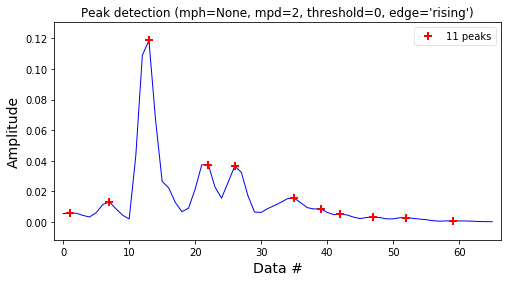

[0.21984551 0.35353535 0.41295306]
[0.11864177 0.0373198  0.03648519]
[0.41295306 0.35353535 0.21984551]
[0.03648519 0.0373198  0.11864177]
0.19696969696969696
mean: 0.00950324100773125
Maximun:  0.05743483943133654


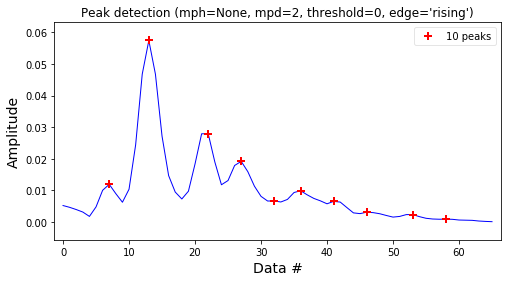

[0.21984551 0.35353535 0.42780749]
[0.05743484 0.02788942 0.01914345]
[0.42780749 0.35353535 0.21984551]
[0.01914345 0.02788942 0.05743484]
0.42424242424242425
mean: 0.005467753235048066
Maximun:  0.013877021587427162


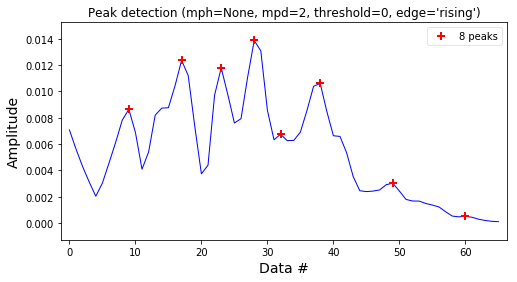

[0.27926322 0.36838978 0.44266191]
[0.01236997 0.01178841 0.01387702]
[0.36838978 0.27926322 0.44266191]
[0.01178841 0.01236997 0.01387702]
0.24242424242424243
mean: 0.005553691241566965
Maximun:  0.016806791709323712


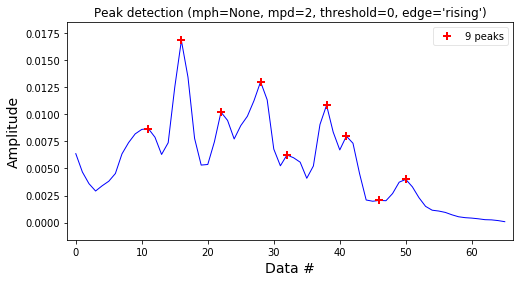

[0.26440879 0.44266191 0.59120618]
[0.01680679 0.01299502 0.01083955]
[0.59120618 0.44266191 0.26440879]
[0.01083955 0.01299502 0.01680679]
0.24242424242424243
mean: 0.005052626628822851
Maximun:  0.015288444983530276


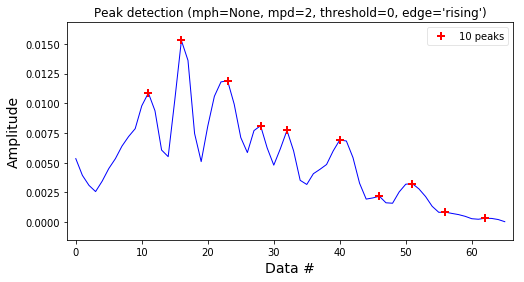

[0.19013666 0.26440879 0.36838978]
[0.01087069 0.01528844 0.01190015]
[0.19013666 0.36838978 0.26440879]
[0.01087069 0.01190015 0.01528844]
0.3484848484848485
mean: 0.00548042212711084
Maximun:  0.013307215346935523


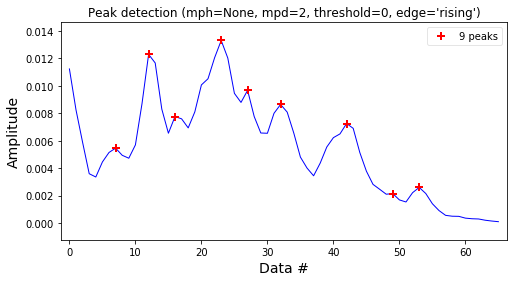

[0.20499109 0.36838978 0.42780749]
[0.01229529 0.01330722 0.00967149]
[0.42780749 0.20499109 0.36838978]
[0.00967149 0.01229529 0.01330722]
0.4696969696969697
mean: 0.00714358616564747
Maximun:  0.0192913996108156


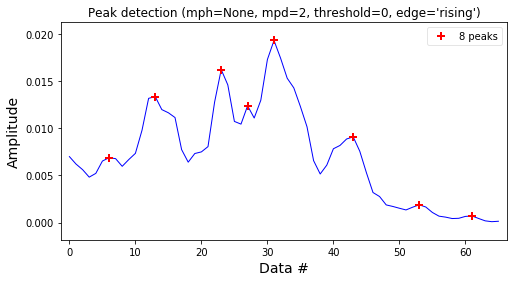

[0.21984551 0.36838978 0.48722519]
[0.01334566 0.01620575 0.0192914 ]
[0.21984551 0.36838978 0.48722519]
[0.01334566 0.01620575 0.0192914 ]
0.4696969696969697
mean: 0.006780414794145435
Maximun:  0.01864079500942326


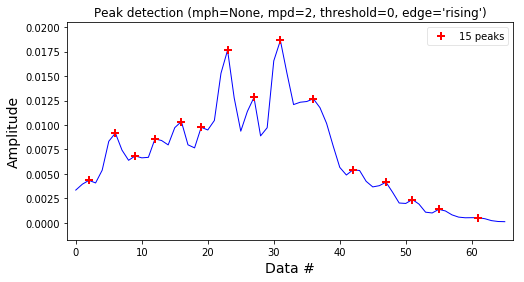

[0.36838978 0.42780749 0.48722519]
[0.01764585 0.01281467 0.0186408 ]
[0.42780749 0.36838978 0.48722519]
[0.01281467 0.01764585 0.0186408 ]
0.42424242424242425
mean: 0.006355361334996942
Maximun:  0.015397896266012552


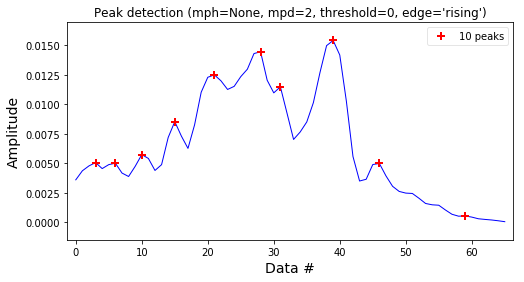

[0.33868093 0.44266191 0.60606061]
[0.01248541 0.01444343 0.0153979 ]
[0.33868093 0.44266191 0.60606061]
[0.01248541 0.01444343 0.0153979 ]
0.5909090909090909
mean: 0.008097560482566235
Maximun:  0.030068183942758786


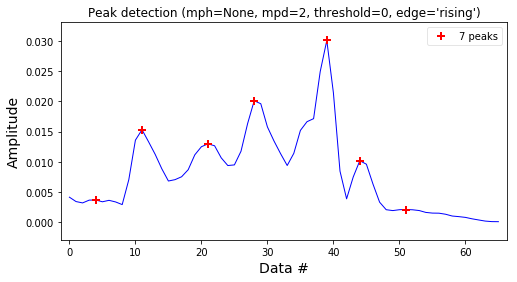

[0.19013666 0.44266191 0.60606061]
[0.01529686 0.02009128 0.03006818]
[0.19013666 0.44266191 0.60606061]
[0.01529686 0.02009128 0.03006818]
0.5757575757575758
mean: 0.006980483420016597
Maximun:  0.017920011436813377


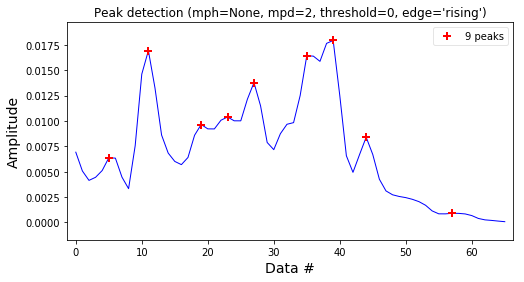

[0.19013666 0.5466429  0.60606061]
[0.01692101 0.01641805 0.01792001]
[0.5466429  0.19013666 0.60606061]
[0.01641805 0.01692101 0.01792001]
0.6060606060606061
mean: 0.11279394025249626
Maximun:  0.8270631938648192


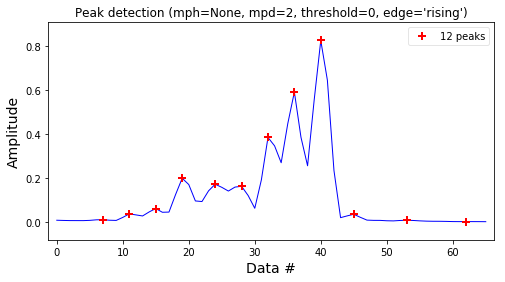

[0.50207962 0.56149733 0.62091503]
[0.38446192 0.59179569 0.82706319]
[0.50207962 0.56149733 0.62091503]
[0.38446192 0.59179569 0.82706319]
0.6060606060606061
mean: 0.11493731676299682
Maximun:  0.8317974479914996


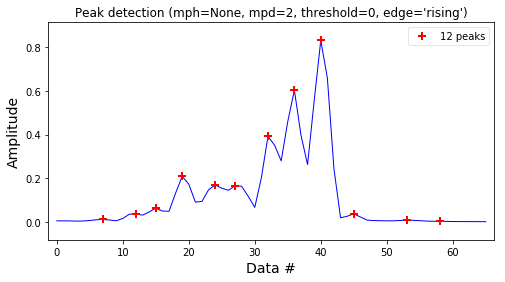

[0.50207962 0.56149733 0.62091503]
[0.39202863 0.60413671 0.83179745]
[0.50207962 0.56149733 0.62091503]
[0.39202863 0.60413671 0.83179745]
0.5606060606060606
mean: 0.007105207385985105
Maximun:  0.019957064962514218


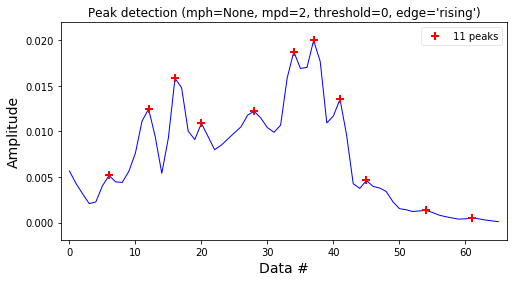

[0.26440879 0.53178847 0.57635175]
[0.01582451 0.01872932 0.01995706]
[0.26440879 0.53178847 0.57635175]
[0.01582451 0.01872932 0.01995706]
0.5151515151515151
mean: 0.00537138849684214
Maximun:  0.016505077007570923


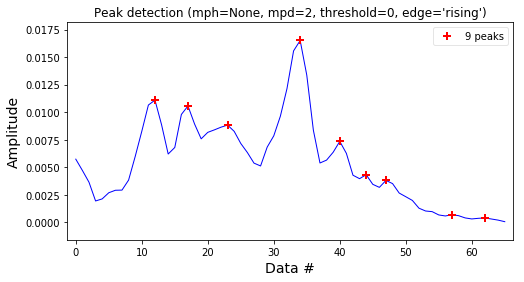

[0.20499109 0.27926322 0.53178847]
[0.01109291 0.01056501 0.01650508]
[0.27926322 0.20499109 0.53178847]
[0.01056501 0.01109291 0.01650508]
0.48484848484848486
mean: 0.006346609785221353
Maximun:  0.01594593566507828


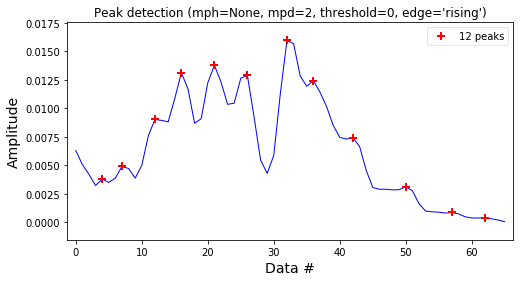

[0.26440879 0.33868093 0.50207962]
[0.01310397 0.0137759  0.01594594]
[0.26440879 0.33868093 0.50207962]
[0.01310397 0.0137759  0.01594594]
0.5454545454545454
mean: 0.00802696189322008
Maximun:  0.02391993998660257


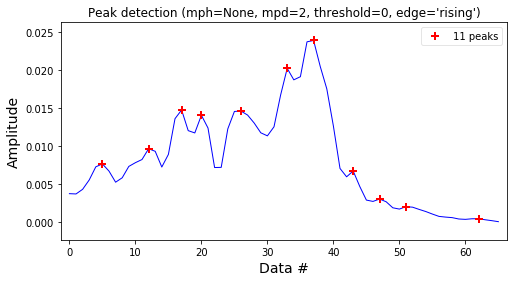

[0.27926322 0.51693405 0.57635175]
[0.01475818 0.02024337 0.02391994]
[0.27926322 0.51693405 0.57635175]
[0.01475818 0.02024337 0.02391994]
0.5454545454545454
mean: 0.00683562639572156
Maximun:  0.018455176277826592


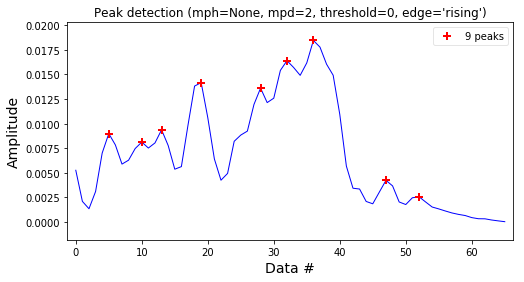

[0.30897207 0.50207962 0.56149733]
[0.0141711  0.01640457 0.01845518]
[0.30897207 0.50207962 0.56149733]
[0.0141711  0.01640457 0.01845518]
0.4696969696969697
mean: 0.00480090085636797
Maximun:  0.011850232159177751


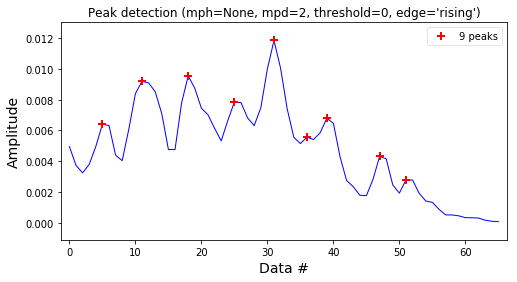

[0.19013666 0.29411765 0.48722519]
[0.00920032 0.00955098 0.01185023]
[0.19013666 0.29411765 0.48722519]
[0.00920032 0.00955098 0.01185023]
0.30303030303030304
mean: 0.00498595990180886
Maximun:  0.011982763446820815


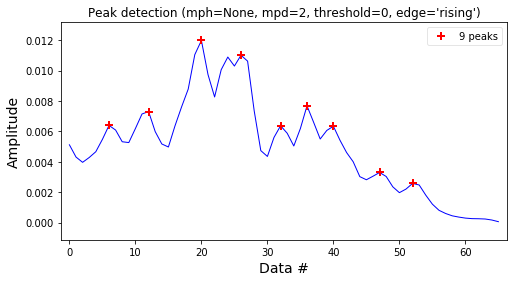

[0.3238265  0.41295306 0.56149733]
[0.01198276 0.01101133 0.00768225]
[0.56149733 0.41295306 0.3238265 ]
[0.00768225 0.01101133 0.01198276]
0.5606060606060606
mean: 0.024558124141979124
Maximun:  0.14778254141930505


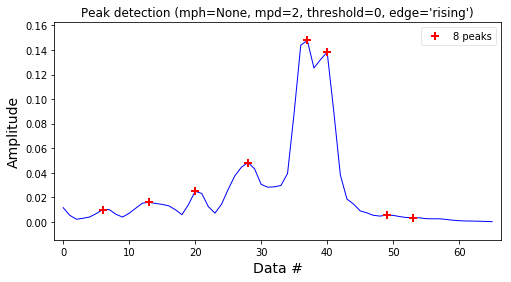

[0.44266191 0.57635175 0.62091503]
[0.04829462 0.14778254 0.1382869 ]
[0.44266191 0.62091503 0.57635175]
[0.04829462 0.1382869  0.14778254]
0.5454545454545454
mean: 0.0702694842007545
Maximun:  0.5445409385538039


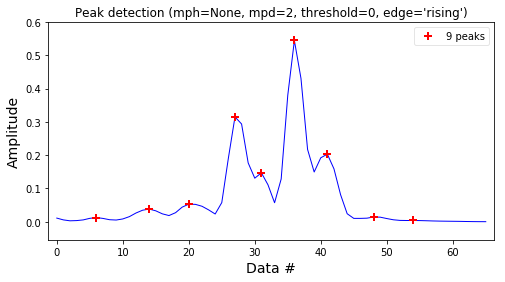

[0.42780749 0.56149733 0.63576946]
[0.31479548 0.54454094 0.20291537]
[0.63576946 0.42780749 0.56149733]
[0.20291537 0.31479548 0.54454094]
0.5454545454545454
mean: 0.05420448065468703
Maximun:  0.40446428211919006


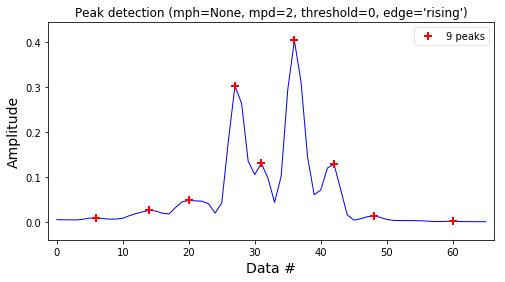

[0.42780749 0.48722519 0.56149733]
[0.3032441  0.13064134 0.40446428]
[0.48722519 0.42780749 0.56149733]
[0.13064134 0.3032441  0.40446428]
0.5606060606060606
mean: 0.01854079770766949
Maximun:  0.0979403377792763


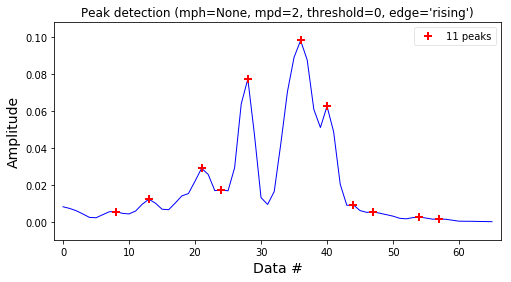

[0.44266191 0.56149733 0.62091503]
[0.0771588  0.09794034 0.06246059]
[0.62091503 0.44266191 0.56149733]
[0.06246059 0.0771588  0.09794034]
0.5606060606060606
mean: 0.015246278477697345
Maximun:  0.07800913537586036


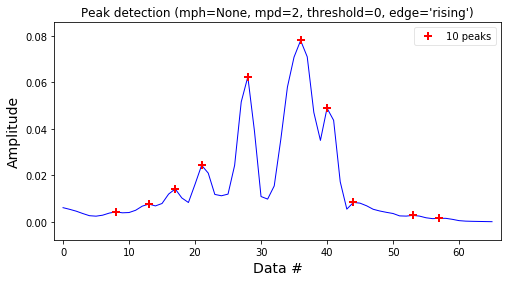

[0.44266191 0.56149733 0.62091503]
[0.062388   0.07800914 0.04891947]
[0.62091503 0.44266191 0.56149733]
[0.04891947 0.062388   0.07800914]
0.5606060606060606
mean: 0.006283883057146447
Maximun:  0.017858237716465233


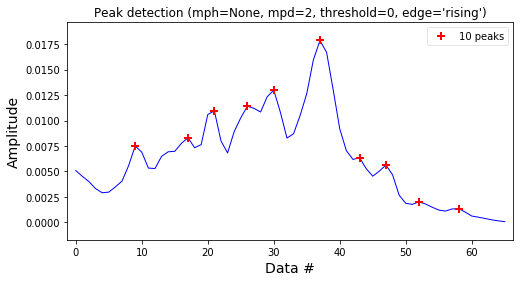

[0.41295306 0.47237077 0.57635175]
[0.01140412 0.0129811  0.01785824]
[0.41295306 0.47237077 0.57635175]
[0.01140412 0.0129811  0.01785824]
0.3787878787878788
mean: 0.04321787048207954
Maximun:  0.41162043042048857


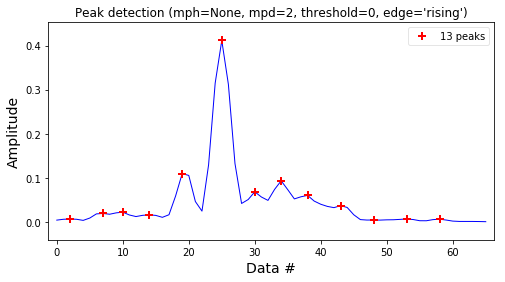

[0.30897207 0.39809863 0.53178847]
[0.10940834 0.41162043 0.09310398]
[0.53178847 0.30897207 0.39809863]
[0.09310398 0.10940834 0.41162043]
0.36363636363636365
mean: 0.05890661507500848
Maximun:  0.4701998630729901


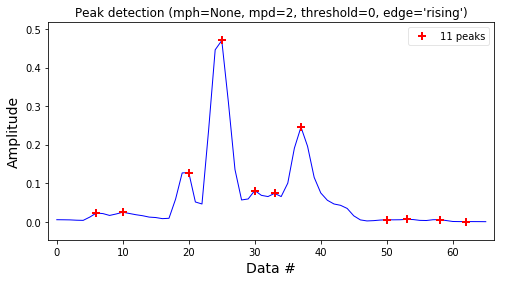

[0.3238265  0.39809863 0.57635175]
[0.12742078 0.47019986 0.24548844]
[0.3238265  0.57635175 0.39809863]
[0.12742078 0.24548844 0.47019986]
0.5606060606060606
mean: 0.02177445630601011
Maximun:  0.14964507824812384


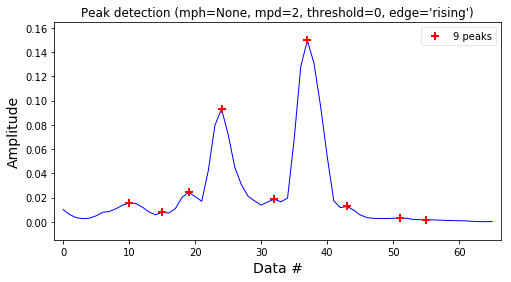

[0.30897207 0.38324421 0.57635175]
[0.02433668 0.0929732  0.14964508]
[0.30897207 0.38324421 0.57635175]
[0.02433668 0.0929732  0.14964508]
0.3787878787878788
mean: 0.004854109244421961
Maximun:  0.013468943422232503


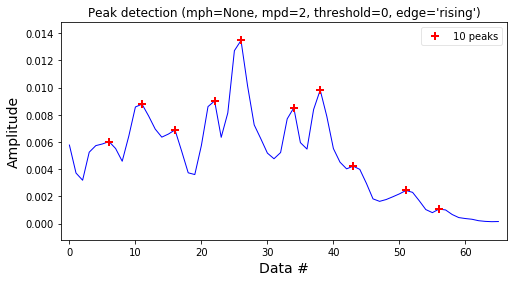

[0.35353535 0.41295306 0.59120618]
[0.00902013 0.01346894 0.00982223]
[0.35353535 0.59120618 0.41295306]
[0.00902013 0.00982223 0.01346894]
0.3333333333333333
mean: 0.004915246829356757
Maximun:  0.01119947569518244


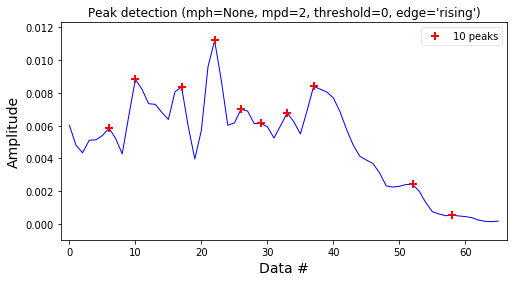

[0.17528223 0.35353535 0.57635175]
[0.00883033 0.01119948 0.00839625]
[0.57635175 0.17528223 0.35353535]
[0.00839625 0.00883033 0.01119948]
0.3333333333333333
mean: 0.004739928359092291
Maximun:  0.010387639786670157


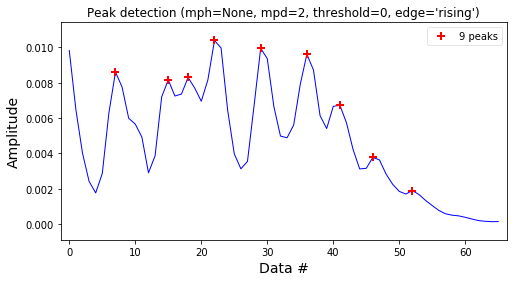

[0.35353535 0.45751634 0.56149733]
[0.01038764 0.00994656 0.00961329]
[0.56149733 0.45751634 0.35353535]
[0.00961329 0.00994656 0.01038764]


In [24]:
for ini, fini in index_list_of_segment(n_spliting_seg):

#for i in np.arange(0,34,s):
    _frequencies, power_spectrum = get_segment_spectrum(signal_seg[ini:fini])
    #index_max = np.argmax(power_spectrum) 
    #print(index_max)
    #print(_frequencies[index_max])
    print(feature_calculators.first_location_of_maximum(power_spectrum))
    print('mean:', np.mean(power_spectrum))
    
    #result = power_spectrum
    result = savgol_filter(power_spectrum, 5, 2)

    #value_to_plot.append(np.std(result))
    #value_to_plot.append(sp.stats.kurtosis(result))
    #value_to_plot.append(np.max(result))
    
    
    #plt.plot(_frequencies, power_spectrum/np.max(power_spectrum))
    #plt.plot(_frequencies, power_spectrum)
    #plt.plot(_frequencies[:len(_frequencies)-1], np.diff(result/np.max(result)))
    #plt.plot(_frequencies, result/np.max(result))
    #ind = detect_peaks(np.log(result),mpd=10,mph=-4, show=True)
    print('Maximun: ',max(result))
    #ind = detect_peaks(result/np.max(result),mpd=2, show=True)
    ind = detect_peaks(result,mpd=2, show=True)
    #Sort min val to max in results
    index_sort = np.sort(ind[np.argsort(result[ind])[-3:]])
    print(_frequencies[index_sort]/normalize_frec)
    print(result[index_sort])
    #Sort min val to max in frecuency values
    index_sort_1 = ind[np.argsort(result[ind])[-3:]]
    print(_frequencies[index_sort_1]/normalize_frec)
    print(result[index_sort_1])
    #print(max(result[index_sort_1]))

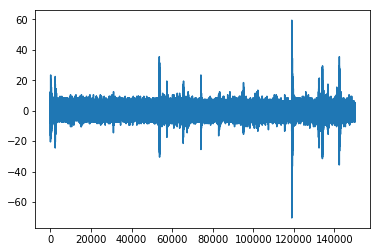

In [102]:
signal_seg['acoustic_data'] -= signal_seg['acoustic_data'].mean() 
plt.plot(signal_seg['acoustic_data'].values)

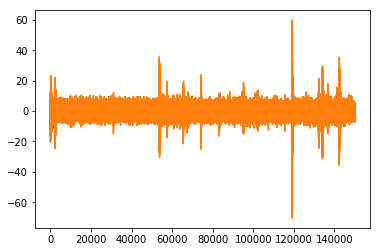

In [148]:

plt.plot(savgol_filter(signal_seg['acoustic_data'][113700:118900].values, 15, 2))

#plt.plot(sp.signal.medfilt(signal_seg['acoustic_data'][118750:118999].values,21))
#plt.plot(signal_seg['acoustic_data'][113700:119000].values)

#plt.plot(sp.signal.medfilt(signal_seg['acoustic_data'][15000:16100].values,11))
plt.plot(signal_seg['acoustic_data'].values)


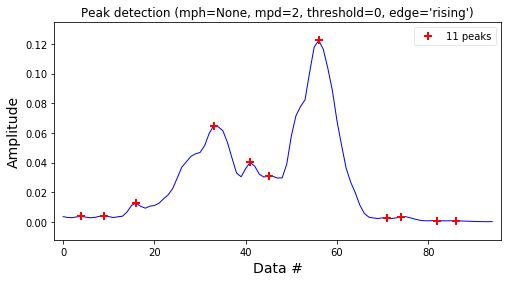

In [149]:
quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_seg[114700:119000])
result = savgol_filter(power_spectrum, 5, 2)
ind = detect_peaks(result,mpd=2, show=True)

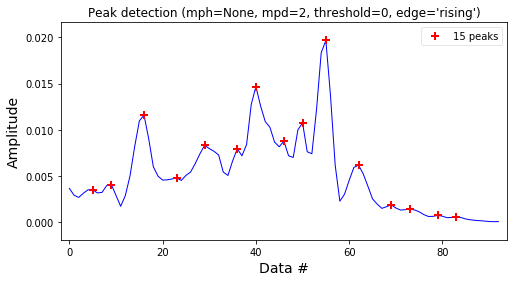

In [150]:
quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_seg[114700:118900])
result = savgol_filter(power_spectrum, 5, 2)
ind = detect_peaks(result,mpd=2, show=True)

In [4]:
scores = []

score_values = [1, 2, 3, 4.0]
scores.append(score_values )
print(scores)


[[1, 2, 3, 4.0]]
